In [1]:
import functools
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

# Wordle word elimination progress graphs

## Load the word list

You will need a downloaded copy of the Wordle JavaScript source code.  The notebook will attempt to download this using the `requests` library, but if that fails, this can be manually downloaded as follows (the instructions are for the FireFox browser, others should be broadly similar):-

* visit the Wordle site https://www.nytimes.com/games/wordle/index.html and right click:"View Page Source" in your browser
* look for a `<script>` tag that contains a reference to the source - it will have the form `main.xxxxxxxx.js` where the `xxxxxxxx` is a string of hexadecimal digits, e.g. `<script src="main.4d41d2be.js"></script>`
* replace the `index.html` in the URL above with the `main.xxxxxxxx.js` (e.g. https://www.nytimes.com/games/wordle/main.4d41d2be.js) then right click:"Save Page As", saving the file under its `main.xxxxxxxx.js` name in the same folder as this notebook

In [2]:
wordle_base_url = "https://www.nytimes.com/games/wordle/"
wordle_url = wordle_base_url + "index.html"

In [3]:
try:
    wordle_js = list(Path().glob("main.????????.js"))[0]
    print(f'Using cached wordle source code: {wordle_js.name}')
except IndexError:
    print(f'Attempting to download the Wordle source code from {wordle_url}')
    req = requests.session()
    try:
        wordle_page = req.get(wordle_url)
    except Exception as e:
        print('Failed to download Wordle source code')
        raise RuntimeError(
            "You must supply Wordle javascript source code as described above."
        )
    _match = re.search(
        r'<script src="(?P<wordle_js>main\.[^.]+.js)"></script>', wordle_page.text
    )
    if _match is not None:
        wordle_js = Path(_match.group("wordle_js"))
        wordle_js_content = req.get(wordle_base_url + wordle_js.name)
        with wordle_js.open("w", encoding=wordle_js_content.encoding) as fd:
            fd.write(wordle_js_content.text)
    else:
        raise RuntimeError(
            "You must supply Wordle javascript source code as described above."
        )

Using cached wordle source code: main.bfba912f.js


In [4]:
with wordle_js.open(encoding="utf-8") as fd:
    wordle_src = fd.read()

The regular expression below is intended to find the word list.  It may fail if the variable name (`Ma` in the below) changes.  If that happens, you will need to examine the source code for the correct variable name and edit the pattern below accordingly.

There are two word lists in the source. You are looking for the first, shorter one.  (The other longer list is the list of allowed guesses.)

In [5]:
word_list_str = re.search(r"Ma=\[([^]]+)\]", wordle_src).group(1)

In [6]:
word_list = list(map(lambda x: x.replace('"', ""), word_list_str.split(",")))

In [7]:
words = pd.DataFrame(data=word_list, columns=["word"])

# Utility functions

The following adds labels to a matplotlib bar chart with the values of each bar.  It's a slight modification of the final function here: http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

In [8]:
def autolabel(ax, rects=None):
    if rects is None:
        rects = ax.patches

    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = height / y_height

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95:  # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            label_position,
            "%d" % int(height),
            ha="center",
            va="bottom",
        )

The following relaxes some `pandas` defaults when displaying a `DataFrame`

In [9]:
wide = pd.option_context("display.max_colwidth", 256, "display.max_columns", None)

# Elimination analysis functions

These functions work on a list of guesses.  Each guess is a `tuple` containing a word (in lower case) and the feedback given by Wordle for that word.

Feedback is encoded as a string of "." (not in the word) "Y" (in the word but in the wrong position) and "G" (right letter in the right position).

e.g. My guesses for Wordle 243 looked like this:-

```
guesses = [
    ("raise", ".Y.YG"),
    ("slate", "G.G.G"),
    ("shade", "GGG.G"),
    ("shape", "GGG.G"),
    ("shake", "GGGGG"),
]
```


In [10]:
def mk_filter_re(guesses):
    """Return a regular expression that encapsulates all information in the guesses."""
    re_slots = {i: None for i in range(5)}
    excluded_by_position = {i: set() for i in range(5)}
    excluded_everywhere = set()

    for guess, feedback in guesses:
        for i, c in enumerate(guess):
            if feedback[i] == "G":
                re_slots[i] = c
                excluded_by_position[i] = set()
            elif feedback[i] == "Y":
                excluded_by_position[i].add(c)
            elif feedback[i] == ".":
                excluded_everywhere.add(c)

    filter_re = "(?="
    for i in range(5):
        if re_slots[i] is not None:
            filter_re += re_slots[i]
        else:
            _excludes = excluded_everywhere.union(excluded_by_position[i])
            if len(_excludes):
                filter_re += "[^" + "".join(sorted(_excludes)) + "]"
            else:
                filter_re += "."
    filter_re += ")"

    for c in functools.reduce(lambda a, b: a.union(b), excluded_by_position.values()):
        filter_re += f"(?=.*{c}.*)"

    return re.compile(filter_re)

A few symbols for the dataframe:-

In [11]:
trans = dict()
trans["."] = "⬛"
trans["Y"] = "🟨"
trans["G"] = "🟩"

Create a `DataFrame` of the guess progress:-

In [12]:
def elimination_progress(guesses):
    data = list()
    for i in range(len(guesses)):
        remaining = words.loc[words["word"].str.match(mk_filter_re(guesses[: i + 1]))]
        feedback = "".join(trans[x] for x in guesses[i][1])
        data.append(
            [
                i + 1,
                guesses[i][0],
                guesses[i][1],
                feedback,
                remaining.shape[0],
                remaining["word"].tolist(),
            ]
        )

    return pd.DataFrame(
        data,
        columns=[
            "Guess #",
            "Guess",
            "Feedback",
            "Feedback Graphical",
            "Words Remaining After Guess",
            "Remaining Words",
        ],
    )

Create a word elimination progress chart

In [13]:
def plot_progress(guesses, number=None):
    df = elimination_progress(guesses)
    ax = df.plot(
        x="Guess #", y="Words Remaining After Guess", kind="bar", color="lightgray"
    )
    # if Number is not supplied, we'll try to determine it from the guesses
    # (only possible if the guess sequence ends with a "GGGGG"!)
    if number is None:
        if guesses[-1][1] == "GGGGG":
            if guesses[-1][0] in word_list:
                number = word_list.index(guesses[-1][0])
    if number is None:
        puzzle = "Wordle"
    else:
        puzzle = f"Wordle{number}"
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_title(f"{puzzle}: Word Elimination Progress")
    ax.set_ylabel("Word Count")
    ax.set_xlabel("Guess")
    sns.despine(offset=10, trim=False, bottom=True)
    autolabel(ax)
    plt.savefig(f"{puzzle.lower()}_progress.png", facecolor="white", transparent=False)
    return ax

# Example:  My progress on Wordle 243

I got this one in 5. My guesses looked like so:-

```
RAISE .Y.YG
SLATE G.G.G
SHADE GGG.G
SHAPE GGG.G
SHAKE GGGGG
```

In [14]:
guesses = [
    ("raise", ".Y.YG"),
    ("slate", "G.G.G"),
    ("shade", "GGG.G"),
    ("shape", "GGG.G"),
    ("shake", "GGGGG"),
]

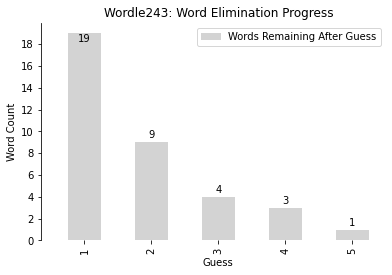

In [15]:
_ = plot_progress(guesses)

In [16]:
with wide:
    display(elimination_progress(guesses))

,Guess #,Guess,Feedback,Feedback Graphical,Words Remaining After Guess,Remaining Words
0,1,raise,.Y.YG,⬛🟨⬛🟨🟩,19,"[shake, shame, spade, stale, shade, stage, slate, usage, shape, space, stake, skate, suave, shale, snake, scale, stave, state, shave]"
1,2,slate,G.G.G,🟩⬛🟩⬛🟩,9,"[shake, shame, spade, shade, shape, space, suave, snake, shave]"
2,3,shade,GGG.G,🟩🟩🟩⬛🟩,4,"[shake, shame, shape, shave]"
3,4,shape,GGG.G,🟩🟩🟩⬛🟩,3,"[shake, shame, shave]"
4,5,shake,GGGGG,🟩🟩🟩🟩🟩,1,[shake]
